# Bay Area Boba EDA

**Question:** What patterns in location and pricing relate to higher ratings?

In [1]:
# Set project root + imports
import sys
from pathlib import Path

# When running notebooks/eda.ipynb, project root is one level up
ROOT = Path.cwd().parent  # -> .../boba-eda-starter
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

try:
    %load_ext autoreload
    %autoreload 2
except Exception:
    pass

# Local imports
from src.clean import clean_pipeline
from src.viz import savefig
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Data load
DATA_PATH = ROOT / "data" / "bayarea_boba_spots.csv"  # Absolute path from ROOT
df = clean_pipeline(DATA_PATH)
df.head()


,id,name,rating,address,city,lat,lon
0,99-tea-house-fremont-2,99% Tea House,4.5,3623 Thornton Ave,Fremont,37.562950,-122.010040
1,one-tea-fremont-2,One Tea,4.5,46809 Warm Springs Blvd,Fremont,37.489067,-121.929414
2,royaltea-usa-fremont,Royaltea USA,4.0,38509 Fremont Blvd,Fremont,37.551315,-121.993850
3,teco-tea-and-coffee-bar-fremont,TECO Tea & Coffee Bar,4.5,39030 Paseo Padre Pkwy,Fremont,37.553694,-121.981043
4,t-lab-fremont-3,T-LAB,4.0,34133 Fremont Blvd,Fremont,37.576149,-122.043705


## Data Dictionary & Assumptions
- `rating`: Yelp star rating (0–5)
- `lat`/`lon`: WGS84 degrees
- `city`: parsed from address; trimmed of whitespace
- Assumptions: ratings are subjective/noisy; no price column in base CSV (add if available).

## Top Cities by Number of Shops

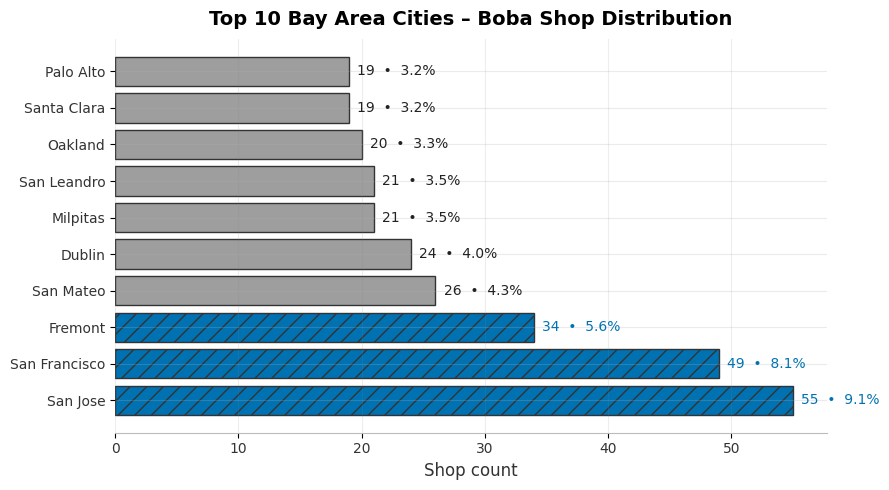

In [2]:
# --- Data prep ---
city_counts = (
    df.groupby("city", as_index=False)
      .size()
      .sort_values("size", ascending=False)
      .head(10)
      .reset_index(drop=True)
)
total_shops = int(df.shape[0])
city_counts["share"] = city_counts["size"] / total_shops

# --- Colors (Okabe–Ito palette for CVD safety) ---
base_color   = "#9E9E9E"   # Neutral gray
accent_color = "#0072B2"   # Blue for top 3
colors = [accent_color if i < 3 else base_color for i in range(len(city_counts))]
hatches = ['//' if i < 3 else '' for i in range(len(city_counts))]  # non-color cue

# --- Plot ---
fig, ax = plt.subplots(figsize=(9, 5), facecolor="white")
bars = ax.barh(city_counts["city"], city_counts["size"], 
               color=colors, edgecolor="#333")

# Apply hatching for top 3
for b, h in zip(bars, hatches):
    if h:
        b.set_hatch(h)

# Title
ax.set_title("Top 10 Bay Area Cities – Boba Shop Distribution",
             fontsize=14, weight="bold", pad=10)

ax.set_xlabel("Shop count", fontsize=12, color="#333")
ax.set_ylabel("")

# Data labels with top 3 in blue
xpad = max(city_counts["size"]) * 0.012
for i, (cnt, share) in enumerate(zip(city_counts["size"], city_counts["share"])):
    label_color = accent_color if i < 3 else "#222"
    ax.text(cnt + xpad, i, f"{cnt}  •  {share:.1%}",
            va="center", fontsize=10, color=label_color)

# Minimal, accessible styling
ax.grid(axis="x", alpha=0.15, color="#888", linewidth=0.8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["bottom"].set_color("#bbb")
ax.tick_params(labelcolor="#333")

plt.tight_layout()
plt.savefig(ROOT / "assets" / "top_cities.png", dpi=300)
plt.show()

**Takeaway:** San Jose and San Francisco together account for ~31% of all Bay Area boba shops,
representing two distinct gravity centers: South Bay scale and SF’s dense urban market.

Fremont emerges as an East Bay demand cluster—driven more by stable suburban consumption 
(commuters + families) than transient tourist traffic.

Mid-tier cities (Dublin, Milpitas, San Leandro, Santa Clara, Palo Alto) form a long tail—
sufficient supply to validate demand, yet not saturated, making them viable testbeds for 
smaller-format or niche operators.

##

## Where Bay Area Boba Shops Cluster (k-Means Analysis)

We looked at the Bay Area boba market at three different resolutions (k=3, k=5, k=10). Each level tells a different story about how competition and quality are distributed.

### 1. Score k = 2..10 (elbow + silhouette)

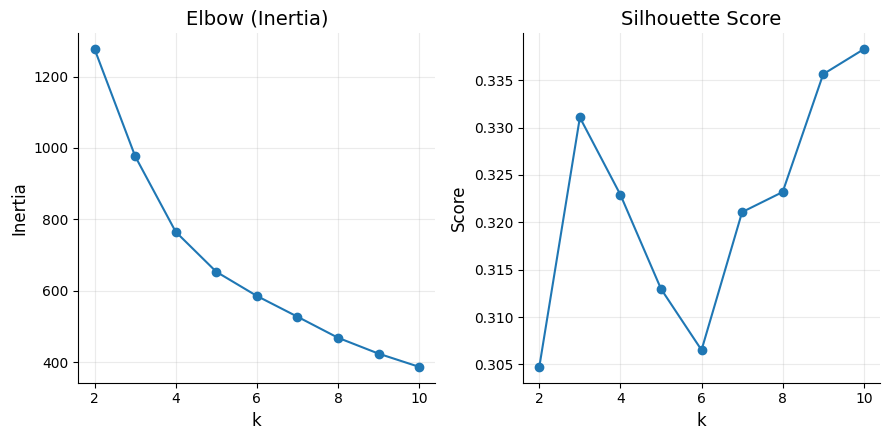

Best k by silhouette: 10 (score=0.338)


In [4]:
# --- Clustering ---
from sklearn.metrics import silhouette_score

# data (robust to lon vs long)
lon_col = "lon" if "lon" in df.columns else "long"
X_raw = df[["lat", lon_col, "rating"]].dropna().copy()

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

ks = range(2, 11)
inertias, sils = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=50, random_state=42)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(X, labels))

fig = plt.figure(figsize=(9,4.5))

# Elbow
plt.subplot(1,2,1)
plt.plot(ks, inertias, marker="o")
plt.title("Elbow (Inertia)"); plt.xlabel("k"); plt.ylabel("Inertia")
plt.grid(alpha=0.25)

# Silhouette
plt.subplot(1,2,2)
plt.plot(ks, sils, marker="o")
plt.title("Silhouette Score"); plt.xlabel("k"); plt.ylabel("Score")
plt.grid(alpha=0.25)

plt.tight_layout()
savefig(ROOT / "assets" / "k_selection.png")
plt.show()

best_k = ks[int(np.argmax(sils))]
print(f"Best k by silhouette: {best_k} (score={max(sils):.3f})")


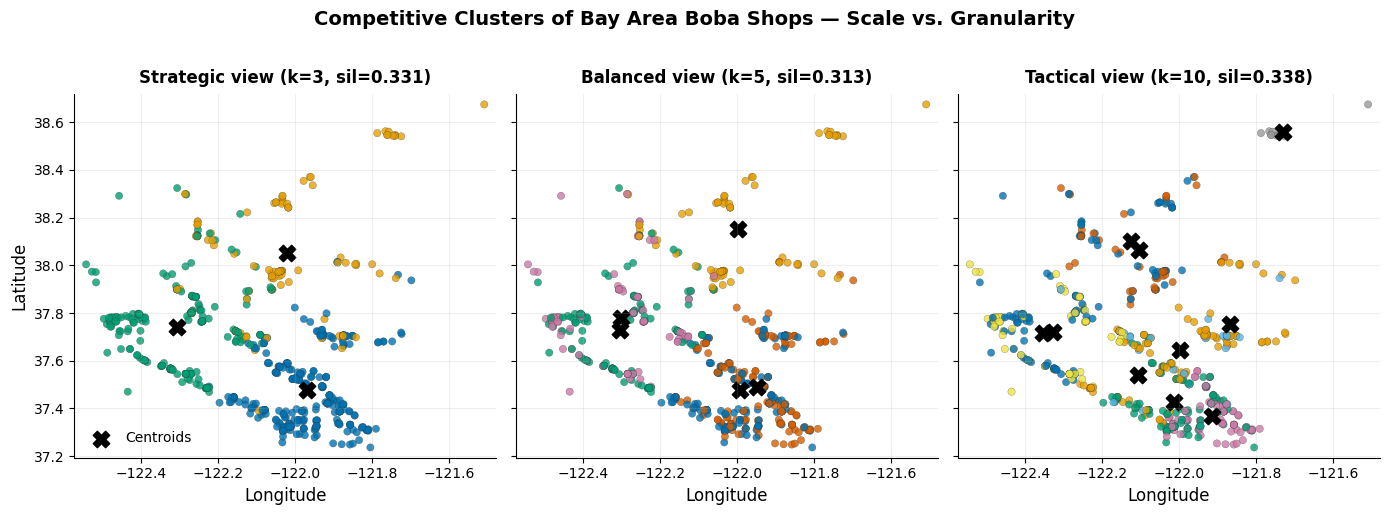

{'k=3': np.float64(0.331), 'k=5': np.float64(0.313), 'k=10': np.float64(0.338)}


In [5]:
# === 3-panel cluster compare: k=3 / k=5 / k=10 ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 0) data (robust to lon/long) + scale
lon_col = "lon" if "lon" in df.columns else "long"
X_raw = df[["lat", lon_col, "rating"]].dropna().copy()

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# nice, color-blind safe palette
okabe_ito = ["#0072B2","#E69F00","#009E73","#D55E00",
             "#CC79A7","#56B4E9","#F0E442","#999999"]

def fit_and_plot(ax, k, show_legend=False, title_prefix=""):
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(X)
    labels = km.labels_
    sil = silhouette_score(X, labels)

    # map labels back to rows used
    df_k = df.copy()
    df_k.loc[X_raw.index, "cluster"] = labels

    # centroids back to (lat, lon, rating)
    cent = scaler.inverse_transform(km.cluster_centers_)

    cmap = ListedColormap((okabe_ito * ((k // len(okabe_ito)) + 1))[:k])

    pts = ax.scatter(
        df_k.loc[X_raw.index, lon_col],
        df_k.loc[X_raw.index, "lat"],
        c=df_k.loc[X_raw.index, "cluster"],
        cmap=cmap, s=28, alpha=0.8, linewidths=0.2, edgecolors="#333"
    )
    ax.scatter(cent[:,1], cent[:,0], c="#000", marker="X", s=140, label="Centroids")

    ax.set_title(f"{title_prefix} (k={k}, sil={sil:.3f})", fontsize=12, weight="bold", pad=8)
    ax.set_xlabel("Longitude")
    ax.grid(alpha=0.2)
    if show_legend:
        ax.legend(frameon=False, loc="lower left")
    else:
        ax.set_ylabel("")  # keep only left subplot with y-label

    return sil

# consistent map bounds across panels
lat_min, lat_max = X_raw["lat"].min(), X_raw["lat"].max()
lon_min, lon_max = X_raw[lon_col].min(), X_raw[lon_col].max()
lat_pad = (lat_max - lat_min) * 0.03
lon_pad = (lon_max - lon_min) * 0.03

fig, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
for ax in axes:
    ax.set_xlim(lon_min - lon_pad, lon_max + lon_pad)
    ax.set_ylim(lat_min - lat_pad, lat_max + lat_pad)
axes[0].set_ylabel("Latitude")

sil3  = fit_and_plot(axes[0], 3, show_legend=True,  title_prefix="Strategic view")
sil5  = fit_and_plot(axes[1], 5, show_legend=False, title_prefix="Balanced view")
sil10 = fit_and_plot(axes[2], 10, show_legend=False, title_prefix="Tactical view")

plt.suptitle("Competitive Clusters of Bay Area Boba Shops — Scale vs. Granularity", fontsize=14, weight="bold", y=1.02)
plt.tight_layout()
savefig(ROOT / "assets" / "boba_clusters_k_3_5_10.png")
plt.show()

print({"k=3": round(sil3,3), "k=5": round(sil5,3), "k=10": round(sil10,3)})


In [8]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# ---------- config ----------
# which k values to profile (change as you like)
k_list = [3, 5, 10]  # or: list(range(3, 11))

# city centers (approx) for nearest-city tagging
CITY_LOOKUP = {
    "San Francisco": (37.7749, -122.4194),
    "San Jose":      (37.3382, -121.8863),
    "Oakland":       (37.8044, -122.2711),
    "Fremont":       (37.5483, -121.9886),
    "Palo Alto":     (37.4419, -122.1430),
    "Berkeley":      (37.8716, -122.2727),
    "Santa Clara":   (37.3541, -121.9552),
    "Milpitas":      (37.4323, -121.8996),
    "Dublin":        (37.7022, -121.9358),
    "San Mateo":     (37.5630, -122.3255)
}

def nearest_city(lat, lon):
    # Euclidean on lat/lon is fine for short distances here
    dists = {city: np.hypot(lat - c_lat, lon - c_lon) for city, (c_lat, c_lon) in CITY_LOOKUP.items()}
    return min(dists, key=dists.get)

# ---------- data prep ----------
lon_col = "lon" if "lon" in df.columns else "long"
feat_cols = ["lat", lon_col, "rating"]
X_raw = df[feat_cols].dropna().copy()

scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

# ---------- run for all k and collect summaries ----------
rows = []

for k in k_list:
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(X)
    labels = km.labels_
    sil = silhouette_score(X, labels)

    # centroids back to original units: [lat, lon, rating]
    cents = scaler.inverse_transform(km.cluster_centers_)

    # attach labels only for rows used in X_raw
    tmp = df.loc[X_raw.index, ["lat", lon_col, "rating"]].copy()
    tmp["cluster"] = labels

    # per-cluster size & avg rating (actual, not centroid)
    stats = tmp.groupby("cluster").agg(
        cluster_n=("cluster", "size"),
        avg_rating=("rating", "mean")
    ).reset_index()

    # build summary rows
    for cid, (clat, clon, crate) in enumerate(cents):
        city = nearest_city(clat, clon)
        n = int(stats.loc[stats["cluster"] == cid, "cluster_n"].values[0])
        avg_r = float(stats.loc[stats["cluster"] == cid, "avg_rating"].values[0])
        rows.append({
            "k": k,
            "cluster_id": cid,
            "nearest_city": city,
            "centroid_lat": round(clat, 4),
            "centroid_lon": round(clon, 4),
            "centroid_avg_rating": round(crate, 2),
            "cluster_n": n,
            "cluster_avg_rating": round(avg_r, 2),
            "silhouette_k": round(sil, 3),
        })

summary_df = pd.DataFrame(rows).sort_values(["k", "cluster_n"], ascending=[True, False]).reset_index(drop=True)
summary_df


,k,cluster_id,nearest_city,centroid_lat,centroid_lon,centroid_avg_rating,cluster_n,cluster_avg_rating,silhouette_k
0,3,0,Fremont,37.4756,-121.9697,3.82,285,3.82,0.331
1,3,2,Oakland,37.7421,-122.3084,3.93,213,3.93,0.331
2,3,1,Berkeley,38.0496,-122.0224,3.33,105,3.33,0.331
3,5,3,Fremont,37.4897,-121.9474,4.14,161,4.14,0.313
4,5,0,Fremont,37.4784,-121.9917,3.35,138,3.35,0.313
5,5,2,Oakland,37.7294,-122.3053,4.22,126,4.22,0.313
6,5,4,Oakland,37.7781,-122.3012,3.29,102,3.29,0.313
7,5,1,Berkeley,38.1535,-121.9976,3.68,76,3.68,0.313
8,10,2,Santa Clara,37.4278,-122.0131,3.46,103,3.46,0.338
9,10,0,San Francisco,37.7181,-122.3540,4.19,90,4.19,0.338


### **Macro View (k=3): Broad Regions**

**East Bay (Fremont area)** → ~285 shops, avg rating 3.82
Biggest cluster overall. Strong suburban demand anchored by commuters and families.

**Urban Core (Oakland/SF corridor)** → ~213 shops, avg rating 3.93
Dense, central hub with slightly higher-than-average shop quality.

**North Bay fringe (Berkeley edge)** → ~105 shops, avg rating 3.33
Smallest cluster, lowest average ratings—suggests fragmented, less consistent market.

At this level, you mainly see “suburbs vs. urban vs. fringe.”

### **Meso View (k=5): Quality Splits Inside Regions**

#### Fremont divides into two:

**Core pocket**: 161 shops, avg rating 4.14 (strong quality).

**Spillover**: 138 shops, avg rating 3.35 (weaker, oversupply).

#### Oakland divides into two:

**High-performers**: 126 shops, avg rating 4.22.

**Mixed**: 102 shops, avg rating 3.29.

#### Berkeley: 76 shops, avg rating 3.68 (remains a modest mid-tier pocket).

Zooming in shows “quality bifurcation”: both Fremont and Oakland hide a mix of premium nodes vs. commodity spillovers.

### **Micro View (k=10): Local Hotspots & Weak Spots**

#### Strong Gravity Wells:

**San Francisco**: 90 shops, avg rating 4.19.

**San Jose**: 80 shops, avg rating 4.11.

**Palo Alto**: 67 shops, avg rating 4.21.
These form premium, consistently strong sub-markets.

#### Underperformers / Risk Areas:

**Santa Clara**: 103 shops, avg rating 3.46 → high shop count, lower quality.

**Dublin (split)**: one cluster at 3.90, another at 2.67 → oversaturation, uneven quality.

**Berkeley fragments**: from 3.27 (weak) to 4.21 (elite blocks). Hyper-local winners vs. losers.

**Oakland**: ~80 shops, avg rating 3.42 → stays mid-tier at this resolution.

At this fine scale, the Bay Area market polarizes: SF/SJ/Palo Alto = strong bets; Santa Clara/Dublin/parts of Berkeley = risky, oversupplied zones.

### **Key Takeaway**

**k=3:** The Bay Area splits broadly into East Bay suburbs, Urban Core, and North Bay fringe.

**k=5:** Fremont + Oakland show internal splits between “premium cores” and weaker spillover zones.

**k=10:** You see true hotspots (SF, SJ, Palo Alto) and clear warning zones (Santa Clara, Dublin, parts of Berkeley).

This progression shows how clustering reveals more nuance: what looks like one big East Bay blob at k=3 breaks into high vs. low quality neighborhoods by k=10. For a potential shop owner, the question shifts from “which city?” to “which block?”.